In [1]:
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
#from fbprophet import Prophet
import datetime 
import warnings 
from fbprophet import Prophet
warnings.simplefilter('ignore')

In [24]:
df = pd.read_csv("../dataset/inout.csv")

In [3]:
def change_date_format(date):
    """We want to have this format for the prophet API : YYYY-MM-DD HH:MM:SS"""
    return datetime.datetime.strptime(date, '%d/%m/%Y %H:%M').strftime('%Y-%m-%d %H:%M:00')

In [25]:
mydf=df[['Horodate_UTC','RES1_BASE']]
mydf["Horodate_UTC"]=mydf["Horodate_UTC"].apply(change_date_format)
mydf=mydf.rename(columns={"Horodate_UTC":"ds","RES1_BASE":"y"})

In [26]:
def split(df):
    mask = df["ds"]<"2017-01-01 00:00:00"
    df= df[mask]
    mask_pred = (df["ds"] > "2016-06-01 00:00:00" ) & (df["ds"] <= "2016-12-31 23:30:00")
    return df[~mask_pred],df[mask_pred]

In [27]:
mydf_past,mydf_forecast=split(mydf)

In [70]:
m=Prophet(interval_width=0.95)
m.add_country_holidays(country_name='FR')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(mydf_past)

Initial log joint probability = -1258.47


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        112336    0.00329795        7871.1      0.3671      0.3671      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        112451    0.00104532       1131.72           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        112487   0.000855782       591.702           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        112517   0.000777039       2890.55      0.1489      0.1489      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        112538    0.00328386        1098.1           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [95]:
NB_PRED=2000

In [97]:
future=m.make_future_dataframe(periods=NB_PRED,freq= '30min')
forecast=m.predict(future)

In [98]:
print(forecast.shape)
print(mydf_past.shape)
print(mydf_forecast.shape)

(48133, 58)
(46133, 2)
(10271, 2)


In [99]:
y_hat=forecast["yhat"][-NB_PRED:]
print(y_hat.shape)

(2000,)


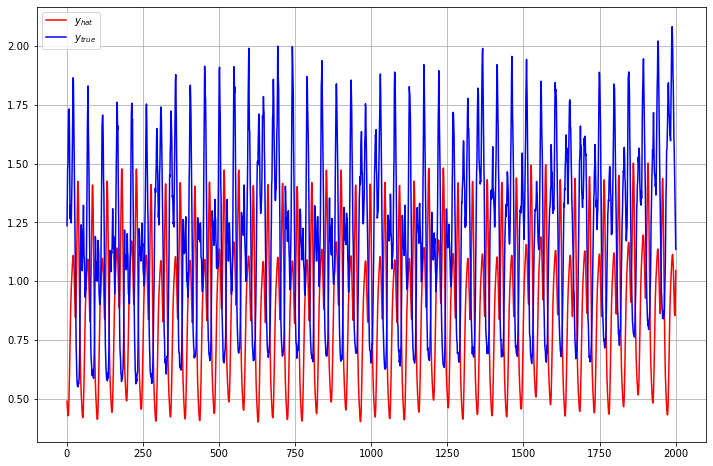

In [100]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,len(y_hat),len(y_hat)),y_hat,c="r",label="$y_{hat}$")
plt.plot(np.linspace(1,len(y_hat),len(y_hat)),mydf_forecast["y"][-NB_PRED:],c="b",label="$y_{true}$")
plt.legend()
plt.grid()
plt.show()